In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

sns.set(rc={'figure.figsize': (15,9)}) 

In [2]:
data = pd.read_excel("2_5210939182918146122.xlsx")
data.head(10)

,Дата,Количество пользователей
0,2022-02-03 00:00:00,0
1,2022-02-03 00:01:00,0
2,2022-02-03 00:02:00,0
3,2022-02-03 00:03:00,0
4,2022-02-03 00:04:00,0
5,2022-02-03 00:05:00,0
6,2022-02-03 00:06:00,0
7,2022-02-03 00:07:00,0
8,2022-02-03 00:08:00,0
9,2022-02-03 00:09:00,0


In [3]:
pd.isnull(data).sum()

Дата                        0
Количество пользователей    0
dtype: int64

In [4]:
data.describe()

,Количество пользователей
count,1440.000000
mean,951.282639
std,1054.902300
min,0.000000
25%,0.000000
50%,163.500000
75%,2115.750000
max,3279.000000


In [5]:
data.columns = ['Date', 'Amount'] 

In [6]:
df = data.iloc[240:]

In [7]:
df

,Date,Amount
240,2022-02-03 04:00:00,0
241,2022-02-03 04:01:00,0
242,2022-02-03 04:02:00,0
243,2022-02-03 04:03:00,22
244,2022-02-03 04:04:00,0
...,...,...
1435,2022-02-03 23:55:00,0
1436,2022-02-03 23:56:00,0
1437,2022-02-03 23:57:00,0
1438,2022-02-03 23:58:00,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Amount'>

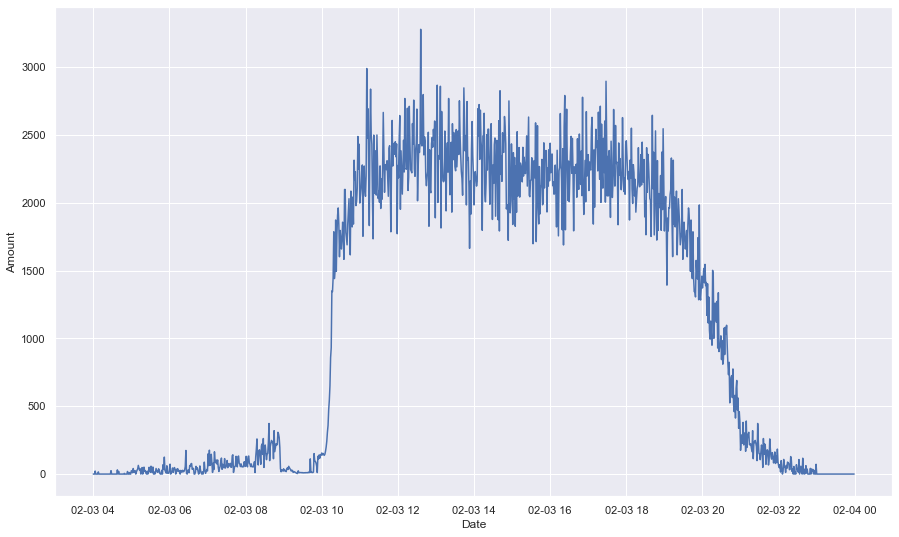

In [8]:
sns.lineplot(df.iloc[:, 0], df.iloc[:, 1])

In [9]:
users = df[(df['Date'] > '2022-02-03 08:53:00') & (df['Date'] < '2022-02-03 10:16:00')]

In [10]:
users.Amount.sum()

8203

In [11]:
a = df.Amount[8*60+53]
b = df.Amount[10*60+16]

In [12]:
S = (a+b)/2 * ((10*60 + 16) - (8*60 + 53)) - a - b

In [13]:
S = round(S)
S

65570

In [14]:
lost_1 = S - users.Amount.sum()
lost_1

57367

Если посчитать площадь под графиком как площадь прямоугольной трапеции, где крайними точками будут моменты появления и окончания проблем на сайте, то потери пользователей составляют 57367.

Далее апроксимируем потерянные данные по 20 точкам с помощью полиномов 1, 2 и 3 порядков.

In [15]:
x = np.array([524,525,526,527,528,529,530,531,532,533,616,617,618,619,620,621,622,623,624,625])
y = np.array([113,320,165,193,223,215,217,308,296,269,1350,1345,1448,1786,1441,1500,1873,1495,1765,1908])
t1 = np.polyfit(x,y,1)
f1 = np.poly1d(t1)
print(f1)

 
14.84 x - 7614


In [16]:
from scipy import integrate
def g1(x):
    return 14.84*x - 7614
v1, err = integrate.quad(g1, 534, 615)
lost_21 = round(v1 - users.Amount.sum())
lost_21

65635

In [17]:
t2 = np.polyfit(x,y,2)
f2 = np.poly1d(t2)
print(f2)

        2
0.2142 x - 231.3 x + 6.263e+04


In [18]:
from scipy import integrate
def g2(x):
    return 0.2142*x*x - 231.3*x + 6.263e+04
v2, err = integrate.quad(g2, 534, 615)
lost_22 = round(v2 - users.Amount.sum())
lost_22

37321

In [19]:
t3 = np.polyfit(x,y,3)
f3 = np.poly1d(t3)
print(f3)

          3         2
0.004037 x - 6.743 x + 3757 x - 6.978e+05


In [20]:
from scipy import integrate
def g3(x):
    return 0.004037*x*x*x - 6.743*x*x + 3757*x - 6.978e+05
v3, err = integrate.quad(g3, 534, 615)
lost_23 = round(v3 - users.Amount.sum())
lost_23

44955

Полином 1го порядка - потери 65635 пользователей
Полином 2го порядка - потери 37321 пользователей
Полином 3го порядка - потери 44955 пользователей


In [21]:
round((df.Amount.sum()-users.Amount.sum())/1440*83 - users.Amount.sum())

70281

При замене потерянных данных средним значением потери составляют 70281 пользователь.

In [22]:
x = np.array([524,525,526,527,528,529,530,531,532,533,616,617,618,619,620,621,622,623,624,625]).reshape((-1, 1))
y = np.array([113,320,165,193,223,215,217,308,296,269,1350,1345,1448,1786,1441,1500,1873,1495,1765,1908])

In [23]:
model = LinearRegression().fit(x, y)

In [24]:
R2 = model.score(x, y)

In [25]:
print('coefficient of determination:', R2)

coefficient of determination: 0.9642078835498111


При таком значении R^2 разумно использовать линейную регрессию

In [26]:
print('intercept:', model.intercept_)

intercept: -7614.358561845356


In [27]:
print('slope:', model.coef_)

slope: [14.84048488]


In [28]:
y_pred = model.predict(x)
y_pred = model.intercept_ + model.coef_ * x

In [29]:
x_ = np.array([534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615])

In [30]:
x_new = x_.reshape((-1, 1))
y_new = model.predict(x_new)

In [31]:
d2 = {"Time_code": x_,"Predict_amount": y_new}
df2 = pd.DataFrame(d2)
df2

,Time_code,Predict_amount
0,534,310.460362
1,535,325.300847
2,536,340.141332
3,537,354.981817
4,538,369.822302
...,...,...
77,611,1453.177698
78,612,1468.018183
79,613,1482.858668
80,614,1497.699153


In [32]:
df2.Predict_amount.describe()

count      82.000000
mean      911.500000
std       353.430024
min       310.460362
25%       610.980181
50%       911.500000
75%      1212.019819
max      1512.539638
Name: Predict_amount, dtype: float64

In [33]:
round(y_new.sum()-users.Amount.sum())

66540

При использовании воссоздания данных с помощью линейной регресиии потери составляют 66540 пользователей.

Выводы: 
1. При полученном коэффициенте детерминации R^2 = 0.96 можно использовать линейную регрессию (потери 66540)
2. Апроксимация многочленами 2 и 3 порядка ведет к потере данных, уместна апроксимация многочленом 1 порядка (потери 65635)
3. Для грубой оценки можно использовать замену потерянных данных средним значением (потери 70281).
4. Геометрическое решение задачи можно использовать для быстрой оценки (потери 57367).
5. Было реализовано решение с помощью данных, взятых со спада графика, визуализация решения прикреплена отдельно. Решение не очень точное, так как фронт и спад графика имеют разные углы наклона, но для быстрой оценки (1-2 минуты) может быть полезно (потери 48615).

Ответ: потери по этому инциденту составляют 66540 пользователей.

In [9]:
name = 'A'


In [10]:
name

'A'